# EEG analysis - part 2

This work is split into coherent, independent parts to keep the notebooks less memory hungry.

In [20]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model, svm
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif
import os
import Queue
import sys
import tarfile
import gzip
import pandas
import random
from pyunicorn.timeseries.recurrence_plot import RecurrencePlot
import nolds
import tensorflow as tf

from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression

from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

import warnings
warnings.filterwarnings("ignore") #, category=DeprecationWarning) 

# %matplotlib inline

## Prepare data

We have 1200 in our dataset. Let's see if we can train a CNN with those.

The channels should be picked based on the most significant coefficients found in the previous section.

In [22]:
channels = ['FP2', 'CZ', 'T4', 'C1', 'O2']
image_size = 256

In [10]:
def load_rps_from_folder(foldername, type_, numfolders=1):
    q = Queue.Queue()
    q.put(foldername)
    cols = ['subject', 'channel', 'rec_plot', 'trial', 'label']
    df_res = pd.DataFrame(columns=cols)
    trials = {}
    
    while not q.empty():
        foldername = q.get()
        for item in os.listdir(foldername):
            item = os.path.join(foldername, item)
            if os.path.isdir(item):
                print('Queueing folder %s' % item)
                q.put(item)
            elif item.endswith('.gz'):
                print('Skipping zipped file %s' % item)
            elif os.path.isfile(item):
                print('Processing file %s' % item)
                if os.stat(item).st_size == 0 or any([not s.isdigit() for s in item[-3:]]):
                    print('A README o empty file, skipping')
                    continue
                no_ext_name = os.path.splitext(os.path.splitext(item)[0])[0]
                subject = no_ext_name[-8] + no_ext_name[-3:]
                df_file = pd.read_table(item, skiprows=5, names=['chan', 'ind', 'val'], \
                                       delim_whitespace=True, usecols=range(1,4), comment='#')
                try:
                    if subject not in trials:
                        trials[subject] = 0
                    else:
                        trials[subject] += 1
                    for key, group in df_file.groupby('chan'):
                        # Pick electrodes far apart with preference to right hemisphere (ass. w\ depression)
                        if key not in channels:
                            continue
                        ts = (df_file.loc[df_file['chan'] == key]['val'].values)
                        rp = RecurrencePlot(ts, threshold=0.1)
                        d = {
                            'subject': subject + type_,
                            'channel': key,
#                             'rec_plot': rp,
                            'rec_plot': [rp.distance_matrix([[30],[30]], 'manhattan').ravel()],
    #                         'rec_plot': pd.Series(list(rp.recurrence_matrix()), dtype=float), # TODO: find a way to convert to a float to plot
                            # We need to keep track of different trials for each subject to make it easier to extract later
                            'trial': trials[subject],
                            'label': no_ext_name[-8]
                        }
                        new_row = pd.DataFrame(d, columns=cols, index=[0])
                        df_res = df_res.append(new_row, ignore_index=True)
                except Exception as e:
                    print("Skipping processing file %s - exception raised: %s" % (item, str(e)))
                    continue
            else:
                raise Exception("Unexpected file %s, this should not happen" % item)
                
    return df_res

df_test = load_rps_from_folder('SMNI_CMI_TEST', 'test')
df_train = load_rps_from_folder('SMNI_CMI_TRAIN', 'train')

Queueing folder SMNI_CMI_TEST/SMNI_CMI_TEST
Queueing folder SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000340
Queueing folder SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000370
Queueing folder SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000375
Queueing folder SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000377
Queueing folder SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000342
Queueing folder SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000347
Queueing folder SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000368
Queueing folder SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000369
Queueing folder SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000371
Queueing folder SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000339
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/README
A README o empty file, skipping
Queueing folder SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000341
Queueing folder SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000372
Queueing folder SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000365
Queueing folder SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000338
Queueing folder SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000364
Queueing folder SMNI_CMI_TEST/SMN

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000340/co2c0000340.rd.043
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000340/co2c0000340.rd.090
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000370/co2a0000370.rd.028
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000370/co2a0000370.rd.024
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000370/co2a0000370.rd.034
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000370/co2a0000370.rd.065
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000375/co2a0000375.rd.042
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000375/co2a0000375.rd.061
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000377/co2a0000377.rd.091
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000377/co2a0000377.rd.105
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000377/co2a0000377.rd.050
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000377/co2a0000377.rd.044
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000342/co2c0000342.rd.059
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000342/co2c0000342.rd.063
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000347/co2c0000347.rd.097
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000347/co2c0000347.rd.095
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000347/co2c0000347.rd.034
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000347/co2c0000347.rd.109
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000368/co2a0000368.rd.020
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000368/co2a0000368.rd.039
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000369/co2a0000369.rd.034
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000369/co2a0000369.rd.022
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000369/co2a0000369.rd.073
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000369/co2a0000369.rd.030
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000371/co2a0000371.rd.061
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000371/co2a0000371.rd.059
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000339/co2c0000339.rd.101
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000339/co2c0000339.rd.058
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000339/co2c0000339.rd.059
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000339/co2c0000339.rd.113
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000341/co2c0000341.rd.085
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000341/co2c0000341.rd.049
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000372/co2a0000372.rd.071
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000372/co2a0000372.rd.045
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000372/co2a0000372.rd.038
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000372/co2a0000372.rd.085
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000365/co2a0000365.rd.101
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000365/co2a0000365.rd.089
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000338/co2c0000338.rd.053
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000338/co2c0000338.rd.063
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000338/co2c0000338.rd.061
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000338/co2c0000338.rd.020
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000364/co2a0000364.rd.089
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000364/co2a0000364.rd.103
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000337/co2c0000337.rd.046
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000337/co2c0000337.rd.083
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000337/co2c0000337.rd.073
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000337/co2c0000337.rd.101
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000346/co2c0000346.rd.059
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000346/co2c0000346.rd.067
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000344/co2c0000344.rd.040
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000344/co2c0000344.rd.042
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Proc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000344/co2c0000344.rd.085
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000344/co2c0000344.rd.083
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Proc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000378/co2a0000378.rd.069
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000378/co2a0000378.rd.055
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Proc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000378/co2a0000378.rd.024
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2a0000378/co2a0000378.rd.020
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Proc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000345/co2c0000345.rd.022
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TEST/SMNI_CMI_TEST/co2c0000345/co2c0000345.rd.036
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calc

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000340/co2c0000340.rd.007
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000340/co2c0000340.rd.054
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000340/co2c0000340.rd.019
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000340/co2c0000340.rd.006
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000370/co2a0000370.rd.020
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000370/co2a0000370.rd.019
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000370/co2a0000370.rd.023
Calculating recur

Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000375/co2a0000375.rd.014
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000375/co2a0000375.rd.008
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000375/co2a0000375.rd.041
Calculating recur

Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000375/co2a0000375.rd.023
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000375/co2a0000375.rd.006
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000375/co2a0000375.rd.029
Calculating recur

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000377/co2a0000377.rd.011
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000377/co2a0000377.rd.041
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000342/co2c0000342.rd.015
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000342/co2c0000342.rd.025
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000342/co2c0000342.rd.029
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000342/co2c0000342.rd.007
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000347/co2c0000347.rd.032
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000347/co2c0000347.rd.065
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000368/co2a0000368.rd.051
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000368/co2a0000368.rd.029
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000368/co2a0000368.rd.047
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000368/co2a0000368.rd.033
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000369/co2a0000369.rd.033
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000369/co2a0000369.rd.014
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000371/co2a0000371.rd.016
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000371/co2a0000371.rd.006
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000371/co2a0000371.rd.008
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000371/co2a0000371.rd.000
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000339/co2c0000339.rd.065
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000339/co2c0000339.rd.030
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000341/co2c0000341.rd.031
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000341/co2c0000341.rd.006
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000341/co2c0000341.rd.041
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000341/co2c0000341.rd.008
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000372/co2a0000372.rd.015
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000372/co2a0000372.rd.009
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000365/co2a0000365.rd.051
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000365/co2a0000365.rd.049
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000365/co2a0000365.rd.035
Calculating recur

Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000365/co2a0000365.rd.055
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000365/co2a0000365.rd.015
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000338/co2c0000338.rd.009
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000338/co2c0000338.rd.021
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000364/co2a0000364.rd.037
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000364/co2a0000364.rd.057
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000364/co2a0000364.rd.061
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000364/co2a0000364.rd.015
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000337/co2c0000337.rd.017
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000337/co2c0000337.rd.002
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000346/co2c0000346.rd.019
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000346/co2c0000346.rd.006
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000346/co2c0000346.rd.009
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000346/co2c0000346.rd.033
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000344/co2c0000344.rd.011
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000344/co2c0000344.rd.012
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000344/co2c0000344.rd.031
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000344/co2c0000344.rd.049
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000378/co2a0000378.rd.012
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000378/co2a0000378.rd.033
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000345/co2c0000345.rd.010
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000345/co2c0000345.rd.033
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000345/co2c0000345.rd.029
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Processing file SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2c0000345/co2c0000345.rd.003
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


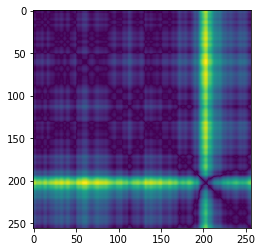

In [5]:
matrix = df_test.iloc[1]['rec_plot']
matrix.resize((image_size, image_size))
plt.imshow(matrix)
plt.show()

In [12]:
df_test.to_pickle('rps_test.pickle')
df_train.to_pickle('rps_train.pickle')

In [52]:
df_test = pd.read_pickle('rps_test.pickle')
df_train = pd.read_pickle('rps_train.pickle')

In [53]:
df_concat = pd.concat((df_train, df_test), axis=0)

df_concat = shuffle(df_concat)

In [54]:
df_concat.shape

(4800, 5)

## Train a CNN

We will take a few trials from the test dataset to provide a validation dataset. It would have been better to do a cross-validation of course - we will do so on the real EEG data. Moreover, we want to prepare the data into 4D array such that the indeces are `subj_trial, row_num, col_num, chan`. 

In [55]:
num_channels = len(channels)
num_labels = 2
num_test_subjects = len(df_test.groupby('subject'))
num_train_subjects = len(df_train.groupby('subject'))
num_trials = max(df_test['trial'].max(), df_train['trial'].max())
num_rows = df_test.shape[0]

In [56]:
def make_dataset(df):
    # We need to make ind. df subject names to ints - will treat them as indeces for ind. dataset
    df['subject'], _ = (df['subject'].astype(str) + df['trial'].astype(str)).factorize()
    df['channel'], _ = df['channel'].factorize()
    df['label'], _ = df['label'].factorize()    
    
    dataset = np.ndarray((df['subject'].max()+1, image_size, image_size, num_channels), dtype=np.float32)
    labels = np.ndarray((df['subject'].max()+1), dtype=np.int8)
        
    row_iterator = df.iterrows()
    for ind, row in row_iterator:
        subj = row['subject']
        chan = row['channel']
        row['rec_plot'].resize((image_size, image_size))
        dataset[subj, :, :, chan] = row['rec_plot']
        labels[subj] = row['label']
    
    return dataset, labels

dataset, labels = make_dataset(df_concat)
dataset.shape, labels.shape

((1200, 256, 256, 5), (1200,))

In [57]:
with open('dataset.pickle', 'wb') as save_file:
    pickle.dump(dataset, save_file, -1)
    
with open('labels.pickle', 'wb') as save_file:
    pickle.dump(labels, save_file, -1)

In [29]:
def split(dataset, *splits):
    train_dataset, train_labels = dataset[:splits[0]], labels[:splits[0]]
    test_dataset, test_labels = dataset[splits[0]:splits[1]], labels[splits[0]:splits[1]]
    valid_dataset, valid_labels = dataset[splits[1]:], labels[splits[1]:]
    
    return train_dataset, train_labels, test_dataset, test_labels, valid_dataset, valid_labels
    
train_dataset, train_labels, test_dataset, test_labels, valid_dataset, valid_labels = split(dataset, 1100, 1150)

In [30]:
print(train_dataset.shape, test_dataset.shape, valid_dataset.shape)

(1100, 256, 256, 5) (50, 256, 256, 5) (50, 256, 256, 5)


In [37]:
np.histogram(train_labels, bins=2), np.histogram(test_labels, bins=2), np.histogram(valid_labels, bins=2)

((array([531, 569]), array([0. , 0.5, 1. ])),
 (array([25, 25]), array([0. , 0.5, 1. ])),
 (array([1844, 1806]), array([0. , 0.5, 1. ])))

In [ ]:
# TODO: One-hot encode labels

In [19]:
batch_size = 1
beta = 0.9
learning_rate = 0.001

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0, trainable=False)
    
    # Variables
    c1_w = tf.Variable(tf.truncated_normal([3, 3, num_channels, 16], stddev=0.1))
    c1_b = tf.Variable(tf.zeros([16]))
    
    c2_w = tf.Variable(tf.truncated_normal([3, 3, 16, 16], stddev=0.1))
    c2_b = tf.Variable(tf.zeros(16))
    
    c4_w = tf.Variable(tf.truncated_normal([3, 3, 16, 32], stddev=0.1))
    c4_b = tf.Variable(tf.zeros(32))
    
    c5_w = tf.Variable(tf.truncated_normal([3, 3, 32, 32], stddev=0.1))
    c5_b = tf.Variable(tf.zeros(32))
    
    # TODO: This is way too many parameters - we have to do something smarter than just flattening c5 or make
    # c5 smaller
    f7_w = tf.Variable(tf.truncated_normal([119072, 50000], stddev=0.1))
    f7_b = tf.Variable(tf.zeros(50000))
    
    f8_w = tf.Variable(tf.truncated_normal([50000, 10000], stddev=0.1))
    f8_b = tf.Variable(tf.zeros(10000))
    
    f9_w = tf.Variable(tf.truncated_normal([10000, num_labels], stddev=0.1))
    f9_b = tf.Variable(tf.zeros(num_labels))
    
    def model(data):
        # C1: 256x256xnum_channels -> 254x254x16
        c1 = tf.nn.conv2d(data, c1_w, [1, 1, 1, 1], padding='VALID') + c1_b
        c1 = tf.nn.relu(c1)
        shape = c1.get_shape().as_list()
        assert(shape[1] == 254 and shape[2] == 254 and shape[3] == 16), "The shape is %s" % shape
 
        # C2: -> 252x252x16
        c2 = tf.nn.conv2d(c1, c2_w, [1, 1, 1, 1], padding='VALID') + c2_b
        c2 = tf.nn.relu(c2)
        shape = c2.get_shape().as_list()
        assert(shape[1] == 252 and shape[2] == 252 and shape[3] == 16), "The shape is %s" % shape
        
        # S3: -> 126x126x16
        s3 = tf.nn.max_pool(c2, [1,2,2,1], [1,2,2,1], padding='VALID')
        shape = s3.get_shape().as_list()
        assert(shape[1] == 126 and shape[2] == 126 and shape[3] == 16), "The shape is %s" % shape
        
        # Dropout
        s3 = tf.nn.dropout(s3, 0.25)
        
        # C4: -> 124x124x32
        c4 = tf.nn.conv2d(s3, c4_w, [1, 1, 1, 1], padding='VALID') + c4_b
        c4 = tf.nn.relu(c4)
        shape = c4.get_shape().as_list()
        assert(shape[1] == 124 and shape[2] == 124 and shape[3] == 32), "The shape is %s" % shape
        
        # C5: -> 122x122x32
        c5 = tf.nn.conv2d(c4, c5_w, [1, 1, 1, 1], padding='VALID') + c5_b
        c5 = tf.nn.relu(c5)
        shape = c5.get_shape().as_list()
        assert(shape[1] == 122 and shape[2] == 122 and shape[3] == 32), "The shape is %s" % shape

        # S6: -> 61x61x32
        s6 = tf.nn.max_pool(c5, [1,2,2,1], [1,2,2,1], padding='VALID')
        shape = s6.get_shape().as_list()
        assert(shape[1] == 61 and shape[2] == 61 and shape[3] == 32), "The shape is %s" % shape
        
        # Dropout
        s6 = tf.nn.dropout(s6, 0.25)
        
        # F7
        f7_in = tf.contrib.layers.flatten(s6)
#         shape = s4.get_shape().as_list()
#         f5_in = tf.reshape(s4, [shape[0], shape[1] * shape[2] * shape[3]])
        f7 = tf.nn.relu(tf.matmul(f7_in, f7_w) + f7_b)

        # F8
        f8 = tf.nn.relu(tf.matmul(f7, f8_w) + f8_b)
        
        # F9
        f9 = tf.matmul(f8, f9_w) + f9_b

        # Dropout
        f9 = tf.nn.dropout(f9, 0.25)
        
        return f9
    
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
            beta*(tf.nn.l2_loss(c1_w) + tf.nn.l2_loss(c2_w) + tf.nn.l2_loss(c4_w) + \
                  tf.nn.l2_loss(c5_w) + tf.nn.l2_loss(f7_w) + tf.nn.l2_loss(f8_w) + tf.nn.l2_loss(f9_w))
    

    # Optimizer.
#     learning_rate = tf.train.inverse_time_decay(0.05, global_step, 500, 0.85, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))
    print(np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()]))

6453696946


In [20]:
def accuracy(predictions, labels):
    # TODO: Convert 
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [ ]:
num_steps = 10001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
    valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

This network has almost 6.5 billion parameters - there is no chance of training it successfully with the amount of data we have. We will keep it, because we should get much more data later, but in the meantime, we will have to create more efficient network; and this time, we will do it in Keras, for fun.